# Elastic deformation of 2D images

[Code by gangadhar provided on Kaggle](https://www.kaggle.com/gangadhar/nuclei-segmentation-in-microscope-cell-images)

This notebook presents an image augmentation method that uses both local distortion and random affine transformation.

These transformations uses anti-aliasing for high-quality output.

In [1]:
# Import stuff
import numpy as np
import pandas as pd
import cv2

import scipy.interpolate
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

import utility
from tensorflow import keras as k

In [ ]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None, apply_affine=False):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape # the dimensions of the input image (x,y,c)
    shape_size = shape[:2]
    
    if apply_affine:
        # Random affine transformation
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)

        M = cv2.getAffineTransform(pts1, pts2)
        
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    # Local distortion 
    # *tuple unpacks the content of the tuple and passes them as arguments to the function -> collected by *args
    # (random_state.rand(*shape) * 2 - 1) gives a tensor specified by shape filled with univariate random numbers shifted to [-1,1)
    # gaussian filter smooths this array where the std in all direction is specified by sigma (large sigma gives smooth displacement arrays)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha # apply a gaussian filter (smoothing) on a list of displacement values
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx) # apply no shift in z direction
    # sigma => smoothing of displacement vector field
    # alpha => amplitude of displacement vector field

    # meshgrid produces a matrix of all cordinates by combining a 1D array of coordinates in each dim (x:[0,1] y:[0,1] gives [[0,0],[0,1],[1,0],[1,1])
    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    # var = a,b,c assigns a tuple
    # np.reshape(y+dy, (-1, 1)) recasts the output (coord mesh y + y displacement) y coordinates to a onedimensional array (col vector, all lined up in x direction)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))
    #print(indices[0].shape)
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape) # after interpolating all values in single file reshape to input dimensions

In [2]:
# Define function to draw a grid in the plot
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        #cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
        plt.axvline(i)
    for j in range(0, im.shape[0], grid_size):
        #cv2.line(im, (0, j), (im.shape[1], j), color=(255,))
        plt.axhline(j)

# Edge grid lines into an image tensor
def edge_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[0], grid_size):
        im[i,:,:] = 0
    for j in range(0, im.shape[1], grid_size):
        im[:,j,:] = 0


# Load images
base_dir = 'C:/Users/Linus Meienberg/Documents/ML Datasets/Oxford_Pets'

images, masks = utility.get_path_lists(base_dir) # get corresponding lists af all paths

# Use matplotlib instead of cv2 i/o functions
#im = cv2.imread(images[0],1) # second argument = flag that specifies image format 1 => color image
#im_mask = cv2.imread(masks[0])
im = k.preprocessing.image.img_to_array(k.preprocessing.image.load_img(images[0]))
im_mask = k.preprocessing.image.img_to_array(k.preprocessing.image.load_img(masks[0]))
im_mask = im_mask[:,:,:1]
#cv2.imshow('the image',im)
#cv2.imshow('the mask',im_mask)
#utility.display([im,im_mask])

Number of samples: 7390


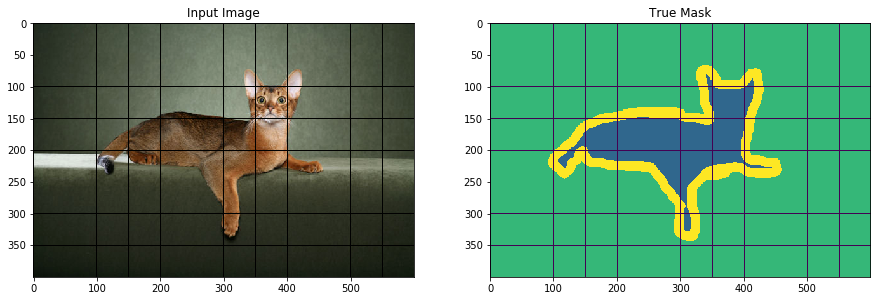

In [9]:
edge_grid(im,50)
edge_grid(im_mask,50)
utility.display([im,im_mask])
#plt.savefig('cato.png')


<Figure size 1152x1008 with 0 Axes>

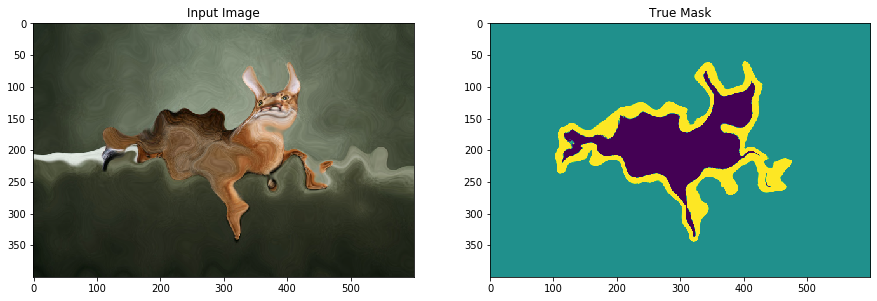

In [85]:
# First sample...

#Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im, im_mask), axis=-1)

%matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 3, im_merge.shape[1] * 2e-2, im_merge.shape[1] * 0.09)

# Split image and mask
im_t = im_merge_t[...,0:3] # First three channels
im_mask_t = im_merge_t[...,3:6] # Second three channels

# Display result
plt.figure(figsize = (16,14))
#plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')
utility.display([im_t,im_mask_t])

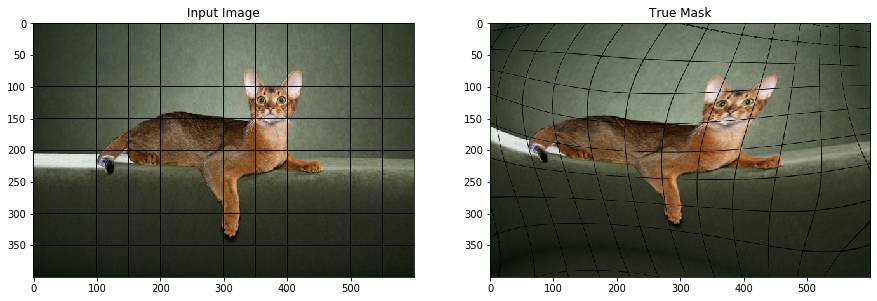

In [119]:
# Second approach : use a displacement field generated by the bicubic interpolation of displacment vectors on a coarse grid


## define grid
input_shape = im.shape # (x,y,c) shape of input image
n_lines = 4 # first and last line coincide with the image border !
grid_x, grid_y = np.linspace(0,input_shape[0],n_lines, dtype=np.integer), np.linspace(0,input_shape[1],n_lines, dtype=np.integer)
#grid_cx, grid_cy = np.meshgrid(grid_x,grid_y) # point n in the mesh has position (grid_cx[n],grid_cy[n])
mesh_size = (len(grid_x),len(grid_y))

## draw displacement vectors on grid
# draw (dx,dy) ~ N(loc,scale) for every entry in the mesh
grid_dx = np.random.normal(loc = 0, scale = 30, size = mesh_size) 
grid_dy = np.random.normal(loc = 0, scale = 30, size = mesh_size) 

## calculate pixel wise displacement by bicubic interpolation
""" 
RectBivariateSpline(x, y, z)
Bivariate spline approximation over a rectangular mesh.
Can be used for both smoothing and interpolating data.

x,y array_like 1-D arrays of coordinates in strictly ascending order.

z array_like 2-D array of data with shape (x.size,y.size).
"""
interpolator_dx = scipy.interpolate.RectBivariateSpline(grid_x, grid_y, grid_dx)
interpolator_dy = scipy.interpolate.RectBivariateSpline(grid_x, grid_y, grid_dy)

def getOriginCords(coords):
    # coords are assumed to be a coordinate tuple (x,y,c)
    x = coords[0] + interpolator_dx.ev(coords[0], coords[1])
    y = coords[1] + interpolator_dy.ev(coords[0], coords[1])
    return (x,y,coords[2])


## calculate origin coordinates for every pixel in output
#xx, yy, cc = np.meshgrid(np.arange(input_shape[0]), np.arange(input_shape[1]), np.arange(3) ) # channel c of pixel n lives at (xx[n*c], yy[n*c], cc[n*c]) (?)
xx, yy = np.meshgrid(np.arange(input_shape[0]),np.arange(input_shape[1]), indexing='ij')
field_dx = interpolator_dx.ev(xx,yy)
field_dy = interpolator_dy.ev(xx,yy)
#indices = np.reshape(xx+field_dx, (-1, 1)), np.reshape(yy+field_dy, (-1, 1)), np.reshape(cc, (-1,1))
# evaluate input image at origin cordinates by interpolation and boundary strategy
#output = map_coordinates(im, indices, order=1, mode='reflect')
# reshape and return output
#output = output.reshape(input_shape)
im_mapped = deformation.applyDisplacementField(im, field_dx, field_dy)

#im_mapped = scipy.ndimage.geometric_transform(im, getOriginCords, mode='reflect')

utility.display([im,im_mapped])

In [110]:
# [::n] take every nth element in this dimension
plt.quiver(range(0,input_shape[0],20),range(0,input_shape[1],20),field_dx[::20,::20],field_dy[::20,::20])
plt.quiver(grid_x,grid_y,grid_dx,grid_dy)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 20 and the array at index 1 has size 30

In [48]:
getOriginCords((200,200,1))

(200.5803475568174, 184.51951805610597, 1)

In [14]:
# Externalize Functionality:
import deformation
from importlib import reload  

In [16]:
reload(deformation)
reload(utility)

<module 'utility' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\Unet1\\utility.py'>

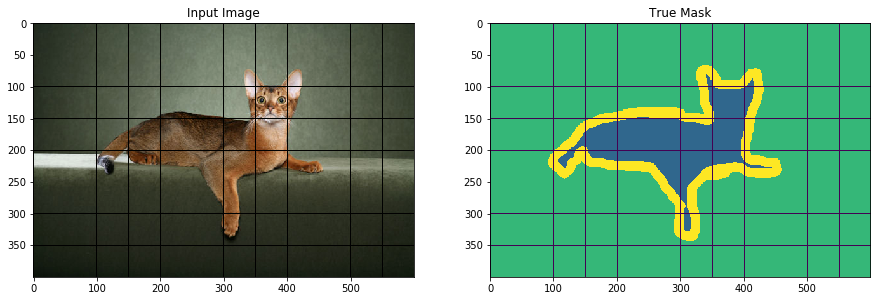

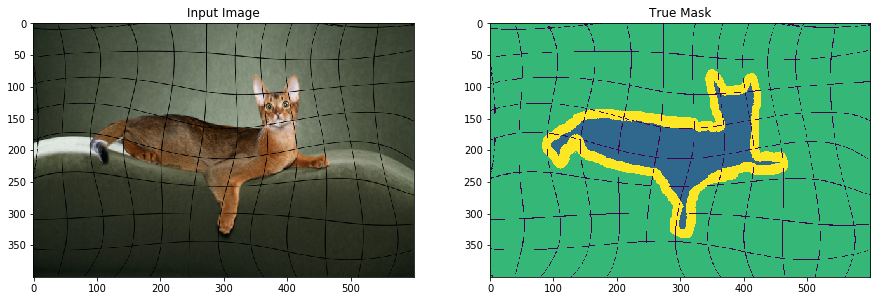

In [21]:
dx, dy = deformation.displacementGridField(im.shape)
im_mapped = deformation.applyDisplacementField(im, dx, dy)
im_mask_mapped = deformation.applyDisplacementField(im_mask, dx, dy, interpolation_order=0)
utility.display([im,im_mask])
utility.display([im_mapped, im_mask_mapped])

In [17]:
mapping = deformation.getCoordinateMappingFromDisplacementField(dx,dy)
mapping((1,1,1))

(9.488244811360426, 7.503561000776273, 1)

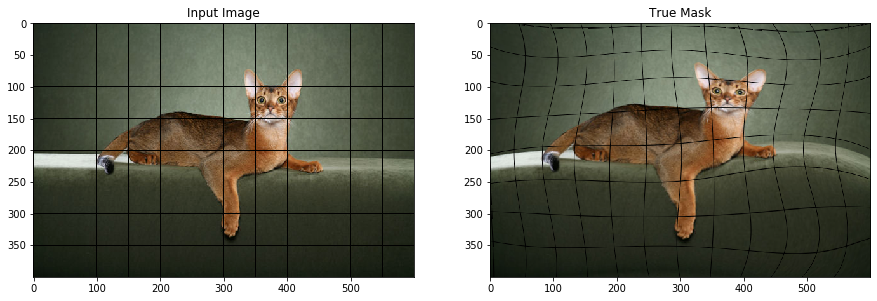

In [20]:
im_mapped_f = deformation.mapImage(im, mapping)
utility.display([im,im_mapped_f])

In [96]:
# Meshgrid produces a list of matrices
# each matrix holds one dimension / coordinate of the points in the meshgrid
coords = np.meshgrid(np.arange(2),['a','b'],['A','B'], indexing='ij')
# the coordinates (x,y,...) of the point (m,n,...) in the grid is accessed like
coords[0][1,0,1], coords[1][1,0,1], coords[2][1,0,1] 
# watch out for differences between the cartesian and matrix enumeration of dimension !

(1, 'a', 'B')